<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [7]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


In [8]:
from datasets import list_datasets

In [9]:
# # 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
# !git clone https://github.com/rickiepark/nlp-with-transformers.git
# %cd nlp-with-transformers
# from install import *
# install_requirements(chapter=6)

In [10]:
from transformers import pipeline, set_seed

# Chapter 6. 요약

요약: 입력 to 출력이 있는 구조 → 인코더-디코더 트랜스포머에 적합

이번 장 목표: 여러 사림이 주고받은 대화 요약

## 6.1 CNN/DailyMail 데이터셋

CNN/DailyMail 데이터셋: 300,000개 뉴스기사 + 요약<br>
3.0.0버전이 익명화 처리를 하지 않았다는 것은 개인정보보호를 위해 보통 이름이나 기관 이름 등을 삭제하는데, 이 버전을 사용할 때는 사용자가 개인정보 보호와 관련된 윤리적, 법적 고려사항에 주의를 기울여서 사용하라는 의도...

In [11]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
# dataset = load_dataset("cnn_dailymail", version="3.0.0")
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  wa

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

특성: ['article', 'highlights', 'id']


In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [13]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [14]:
import pickle

In [15]:
with open('dataset.pickle','wb') as  fw:
  pickle.dump(dataset, fw)

In [16]:
with open('dataset.pickle', 'rb') as fr:
  data_loaded = pickle.load(fr)

In [12]:
data_loaded

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

id: 기사 고유 아이디

In [13]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:800])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])
print('\n')
print(sample["id"])

기사 (500개 문자 발췌, 총 길이: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'

요약 (길이: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up 

※ 대부분의 트랜스포머 모델의 문맥 크기는 1,000개 토큰 정도로 제한<br>
긴 기사의 경우 문맥 크기 제한에 맞춰 잘라야...

In [ ]:
sample

{'article': '(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory 

## 6.2 텍스트 요약 파이프라인

입력 텍스트 2,000자 제한

In [14]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

요약에서는 관례적으로 요약 문장 줄바꿈으로 나눔<br>
마침표마다 그 뒤에 줄바꿈을 하게되면 구두점이 포함된 약어 U.S.이나 U.N. 같은 문자열을 처리하는데 문제가 됨<br>
NLTK 패키지에는 문장의 종결과 약어에 등장하는 구두점을 구별하는 정교한 알고리즘 포함

In [18]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

punkt 토크나이저 모듈: 문장 경계를 자동 식별하도록 훈련된 머신러닝 모델(약어, 이메일 주소, 웹 주소 등 문장 분리 최소화)

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### 6.2.1 요약 기준 모델

일반적인 기준 모델(baseline)은 단순히 기사 처음 세 문장을 선택하는 것

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])                                   # 첫 3문장 선택

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [ ]:
summaries["baseline"]

"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\nThe fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.\nThe U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover."

### 6.2.2 GPT-2

GPT-2에서 입력 텍스트 뒤어 'TL;DR'을 추가하면 요약을 생성함<br>
too long:didn't read<br>
레딧 같은 사이트에서 긴 포스트를 짧게 요약할 때 사용

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)                                                                    # 참고

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
# pipe = pipeline("text-generation", model="gpt2-xl")
pipe = pipeline("text-generation", model="gpt2-large")

gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

max_length: 생성된 텍스트 최대 길이<br>
clean_up_tokenization_spaces: 토크나이제이션 후 생성된 공백을 정리할지 여부를 결정. True로 설정하면 모델 출력에서 불필요한 공백이 제거되어 더 깔끔한 텍스트를 얻을 수 있음. 예를 들어, 특정 토크나이저는 단어와 구두점 사이에 불필요한 공백을 삽입할 수 있는데, 이 파라미터가 이러한 공백을 제거하는 데 도움.


In [ ]:
summaries["gpt2"]

'Bolt finished in the top 5 with a time of 4:03.48 in 2:47.01, beating Gatlin who was 5th with a time of 4:06.82.\nHe won his first world titles in 2012 but has not been as dominant over the years.\nDespite only having made two appearances at the world championships in the last few years, with both coming in the same'

### 6.2.3 T5

Text-to-Text Transfer Transformer 모델<br>
T5는 요약을 포함해 마스킹 단어 재구성을 위한 비지도 학습 데이터와 지도 학습 데이터를 섞어 훈련<br>

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

텍스트-투-텍스트 프레임워크<br>
번역, 요약, CoLA(The Corpus of linguistic acceptability, 언어학적 수용성 평가, 문법적으로 수용가능한지 여부), STSB(The semantic Textual Similarity Benchmark, 두 문장 사이의 유사성 평가) 가능

In [19]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [20]:
summaries["t5"]

"usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .\nthe 26-year-old anchored Jamaica to victory in the event in the Russian capital .\nhe has now collected eight gold medals at the championships, equaling the record ."

요약 괜찮음

### 6.2.4 BART

facebook AI 연구팀<br>
인코더-디코더 구조<br>
요약, 번역, 문장 생성 등 다양한 NLP작업에 효과적<br>
손상된 입력을 재구성하도록 훈련<br>
BERT 인코더와 GPT-2 디코더 결합<br>
노이즈를 추가하고 복원하기(denoising autoencoder): 입력 텍스트에 일부러 노이즈(단어 순서를 뒤섞거나, 일부 단어를 마스킹하거나 삭제하는 등)을 추가하고, 이후 원본 텍스트를 복원하려고 시도하면서 학습

In [21]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
summaries["bart"]

"Usain Bolt wins his third gold of the world championships in Moscow.\nBolt anchors Jamaica to victory in the men's 4x100m relay.\nThe 26-year-old has now won eight gold medals at world championships.\nJamaica's women also win gold in the relay, beating France in the process."

요약 괜찮음

### 6.2.5 PEGASUS

Pre-training with Extracted Gap-sentences for Abstractive SUmmarization Sequence-to-sequence models<br>
Google Research<br>
인코더-디코더 트랜스포머<br>
마스킹 문장을 예측한 것을 목표로 pretrained<br>
문서에서 중요한 문장들을 식별하고, 이를 "갭(gap)"으로 남겨두며 나머지 문서를 이용해 사전 학습을 수행<br>
빠진 문장 복원을 시도하면서 문서 내 중요 정보 추출 및 요약하는 법을 학습

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

모델 내에 줄바꿈 특수 토큰이 있어 sent_tokenize() 함수 필요없음

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
summaries["pegasus"]

"Usain Bolt wins third gold of world championships.\nAnchors Jamaica to victory in men's 4x100m relay.\nEighth gold at the championships for Bolt.\nJamaica also win women's 4x100m relay ."

괜찮게 요약된 것 같음

## 6.3 요약 결과 비교하기

GTP-2: 데이터셋에서 전혀 훈련되지 않음(요약을 생성하도록 훈련되지 않았다는 것인지?)<br>
T5: 요약을 위해 미세 튜닝됨<br>
BART, PEGASUS: 요약만을 위해 미세 튜닝

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay.
The fastest man in the world charged clear of United States rival Justin Gatlin
as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and
Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after
Britain were disqualified for a faulty handover.

GPT2
Bolt finished in the top 5 with a time of 4:03.48 in 2:47.01, beating Gatlin who
was 5th with a time of 4:06.82.
He won his first world titles in 2012 but has not been as dominant over the
years.
Despite only having made two appearances at the world championships in the last
few years, with both coming in the same


어떤 모델이 좋은지 판단 기준에 대해 궁금<br>
지표 하나를 정의하고 특정 벤치마크 데이터셋에서 모든 모델 평가해 성능이 최고인 모델 선택하는 것이 이상적이나 지표를 어떻게 정의해야하느냐가 문제<br>
텍스트 품질 측정을 위한 일반적인 지표 필요<br>

## 6.4 생성된 텍스트 품질 평가하기

생성 텍스트 평가 지표<br>
널리 사용되는 두 지표 BLEU와 ROUGE 소개

### 6.4.1 BLEU

Bilingual Evaluation Understudy<br>
단어 or n-그램 체크<br>
정밀도 근간으로하는 지표<br>
**두 텍스트(생성 텍스트와 참조 텍스트) 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트, 그 후 생성된 텍스트 길이로 나눔<br>
단점: 생성된 텍스트에 동일 단어 반복하고 이 단어가 참조 텍스트에 있을 경우 → 정밀도 높음<br>
보완: 단어를 참조 텍스트에 등장한 횟수만큼만 카운트<br>
참조 텍스트: 'the cat is on the mat'<br>
생성 텍스트: 'the the the the the the'<br>



정밀도 계산(vanilla precision vs modified precision)

Pvanilla = 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트 / 생성된 텍스트 길이<br>
Pmod = 생성 텍스트의 단어가 참조 텍스트에 등장한 횟수만큼만 카운트 / 생성된 텍스트 길이

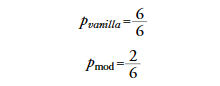

Pmod로 단점을 극복하였다...

---------------------------

위는 단어에 대한 정밀도 계산이고<br>
아래 쪽은 Pmod n-그램 체크로 확장하여 설명 계속 진행

※ n-gram: 연속된 'n'개의 항목(이 경우 주로 단어나 문자)의 시퀀스를 의미<br>
- n-그램의 예시:<br>
-- 1-그램(Unigram): 단일 항목(예: 단어나 문자)을 의미합니다.<br> 예를 들어, 문장 "The cat sat on the mat"의 1-그램은 "The", "cat", "sat", "on", "the", "mat"입니다.<br>
-- 2-그램(Bigram): 연속된 두 항목의 시퀀스를 의미합니다.<br> 같은 문장에서의 2-그램은 "The cat", "cat sat", "sat on", "on the", "the mat"입니다.<br>
-- 3-그램(Trigram): 연속된 세 항목의 시퀀스입니다.<br> 예로 "The cat sat", "cat sat on", "sat on the", "on the mat"가 있습니다

생성 텍스트와 참조 텍스트를 비교할 경우<br>
생성 텍스트 snt 에서 n-gram 수 (분모) vs 참조 문장 snt'에서 n-gram 등장 횟수 (분자)

반복적인 생성에 보상을 주지않도록 분자의 카운트를 클리핑함<br>
→ 생성된 문장에서 n-그램의 등장 횟수를 카운트하는 것이 참조 문장에 나타난 횟수로 제한

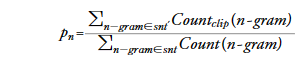

예시. 2-gram인 경우

* chatGPT로 예시를 만들어서 번역으로 표기되었으나 여기서는 요약으로 생각하여 이해해주세요.

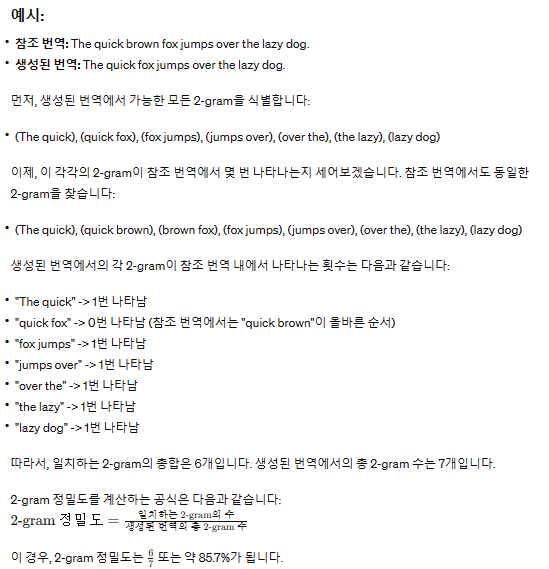

---------------------------

말뭉치 C에 있는 모든 문장으로 확장했을 경우

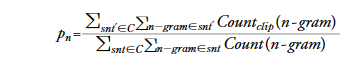

예시. 2문장 말뭉치 C에 대해 BLEU 계산

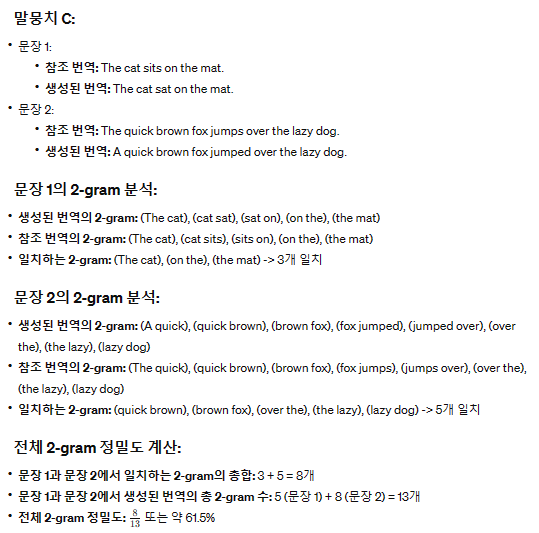

BLEU는 번역된 텍스트가 참조 번역을 얼마나 잘 "재현"하는지보다는,<br> 번역된 텍스트 내의 n-gram이 참조 번역과 얼마나 정확하게 "일치"하는지에 더 큰 비중을 둡니다.<br>


-------------------------

브레비티 페널티(Brevity penalty)<br>
- 기계 번역된 텍스트가 참조 번역보다 너무 짧을 경우 적용되는 패널티
- 이 메커니즘은 번역된 텍스트가 참조 텍스트에 비해 너무 간결하게 요약되어 정보가 손실되는 것을 방지하기 위해
- 짧은 번역은 정밀도를 인위적으로 높일 수 있으나, 이는 반드시 높은 품질의 번역을 의미하지 않기 때문

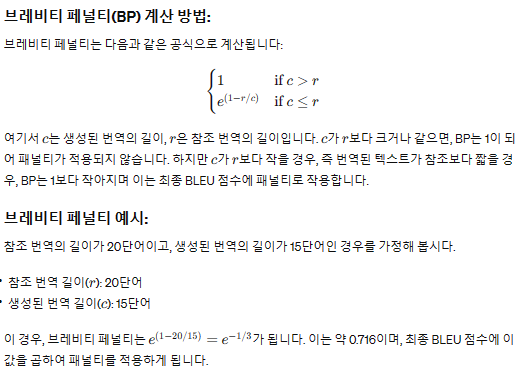

최종적인 BLEU 점수 공식<br>
1에서 N까지 n-그램에서 수정 정밀도의 기하 평균

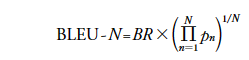

BLEU-4 점수가 많이 사용됨

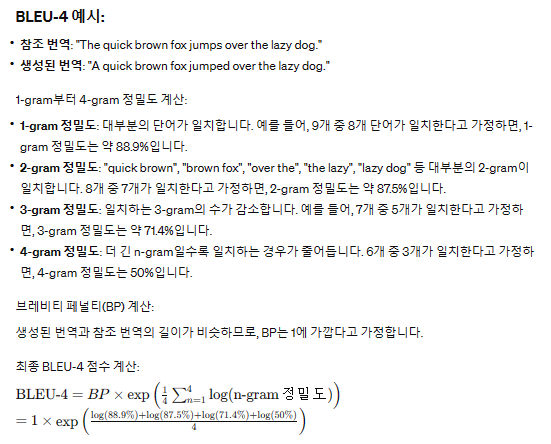

BLEU 단점
- 동의어를 고려하지 않음
- 유도된 식의 많은 단계가 임시방편이고 깨지기 쉬움
- 토큰화된 텍스트를 기대(토큰화를 정확히 같은 방법으로 하지 않으면 결과가 달라짐)<br>
→ SacreBLEU는 토큰화 단계를 내재화하여 이 문제 해결

---------------------------------

SacreBLEU 실습<br>
데이터셋에서 측정지표도 제공

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

add() 샘플 하나 추가<br>
add_batch() 배치 전체 추가<br>
compute() 지표 계<br>
smooth_method="floor"와 smooth_value=0는 점수 계산 시 사용되는 평활화 방법과 그 값


In [ ]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


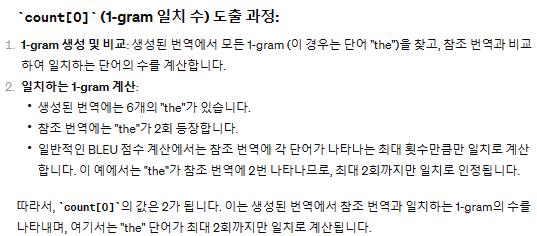

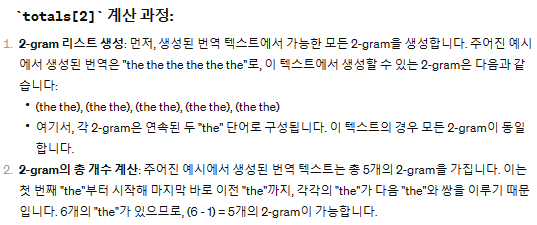

In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


※ 평활화는 특히 생성된 번역에서 특정 n-gram이 참조 번역에 전혀 나타나지 않을 때(즉, 정밀도가 0일 때) 발생할 수 있는 계산 문제를 해결하기 위해 사용됩니다. 정밀도가 0인 n-gram이 존재하면, BLEU 점수의 기하 평균 계산에서 전체 점수가 0이 되는 문제를 방지하기 위해 평활화가 필요합니다. <br>
 smooth_value를 1로 설정하면, 모든 n-gram 정밀도 계산에 최소한 1의 값이 추가됩니다. 이는 특히 생성된 번역에서 높은 n-gram(예: 4-gram)이 참조 번역에 전혀 나타나지 않아 정밀도가 0인 경우에 유용합니다. 평활화를 통해 이러한 n-gram에 작은 가중치를 부여하여, 최종 BLEU 점수가 0이 되는 것을 방지하고, 보다 현실적인 번역 품질 평가를 가능하게 합니다.

BLEU 점수는 기계 번역에 많이 쓰인다.<br>
가능하고 적합한 단어를 모두 포함하는 번역보다 정확한 번역이 선호되기 때문에...

### 6.4.2 ROUGE

여기서 ROUGE-N, ROUGE-L 구분할 줄 알아야...
(교재에는 언급되어 있지않은 ROUGE-W, ROUGE-S도 있음)

Recall-Oriented Understudy for Gisting Evaluation

요약 같은 어플리케이션에는 중요한 정보가 생성된 텍스트에 모두 포함되어야 하므로 높은 재현율이 선호된다.
→ROUGE

생성 텍스트와 참조 텍스트에서 여러 n-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU와 유사<br>
ROUGE는 **분모에서 참조 테스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인**한다는 점이 다름

ROUGE는 분모에서 참조 텍스트의 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지 클리핑하지 않고 카운트하도록 정밀도 공식 수정

그냥 분모가 **참조 텍스트** n-그램의 수다...<br>
BLEU에서는 분모가 **생성 텍스트** n-그램 수

ROUGE 기본 공식(뒤에서 개선된다...)

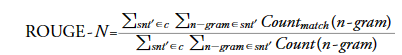

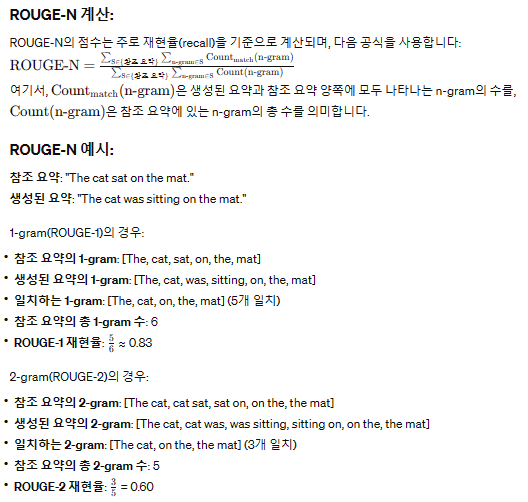

※ BLUE-1 계산과 비교

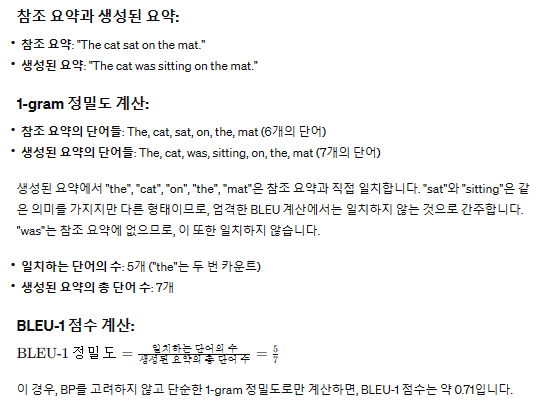

-------------------------------

정밀도를 완전히 제거하고 재현율만 보면 부정적인 영향이 커진다...<br>


→ 해결을 위해,<br>
클리핑 카운트를 하지않는 BLEU 정밀도와 ROUGE 점수를 조화 평균하여 F1-점수 구함<br>
→ 이것이 일반적으로 사용되는 ROUGE 점수

--------------------------------------------

ROUGE-L: 가장 긴 공통 부분 시퀀스(LCS)를 측정하는 별도의 점수

ROUGE-L 메트릭은 생성된 텍스트와 참조 텍스트 간의 유사도를 평가하는 데 사용되며, 특히 최장 공통 부분수열(Longest Common Subsequence, LCS)의 길이를 기반<br>
LCS는 두 시퀀스 간에 순서를 유지하면서 모두에 나타나는 최대 길이의 공통 원소 시퀀스를 찾는 것을 의미<br>
ROUGE-L은 이러한 LCS를 활용하여 생성된 텍스트가 참조 텍스트와 얼마나 유사한 구조와 단어를 가지고 있는지를 평가

ROUGE-L은 재현율(Recall), 정밀도(Precision), 그리고 F1 스코어를 기반으로 계산

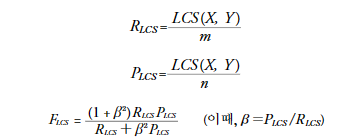

? 베타의 의미가 뭔지 추가 스터디 필요!!!

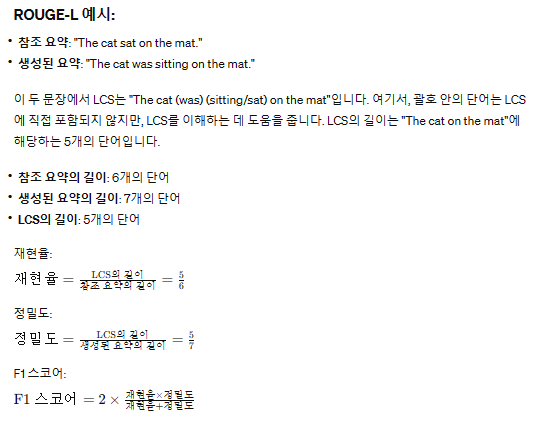

1. ROUGE-L = 문장마다 점수를 계산해서 요약에 대해 평균한 점수
2. ROUGE-Lsum = 전체 요약에 대해 계산한 점수

In [ ]:
rouge_metric = evaluate.load("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.145833,0.021277,0.145833,0.145833
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


논문에서는 CNN/DailyMail 데이터셋에서<br>
PEGASUS 결과가 T5 모다 뛰어나며 적어도 BART에 견줄 만하다고 기대

※ ROUGE 지표는 신뢰구간도 계산(백분위 5~95)

## 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [18]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [19]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
# dataset = load_dataset("cnn_dailymail", version="3.0.0")
dataset = load_dataset("cnn_dailymail", version="3.0.0")
rouge_metric = evaluate.load("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

ValueError: At least one data file must be specified, but got data_files=None

In [ ]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000)) #select(range(10))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388019,0.170517,0.24714,0.354912


빔 서치...고려하면 Forward 연산 횟수 x배로 늘어난다.<br>
시간 오래걸린다...

-----------------------------------------------


실행하지 않고 의미만 해석

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# 배치 사이즈로 주어진 리스트를 나누는 함수
def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        # 토큰화
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")
        # 요약 실행
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        # 사림이 읽을 수 있는 형태로 디코딩
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        # 여러 평가 지표 계산 라이브러리에서 찾아볼 수 있는 함수
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [23:44<00:00, 11.39s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427195,0.207378,0.305054,0.36919


In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427195,0.207378,0.305054,0.36919


## 6.6 요약 모델 훈련하기

SAMSum 데이터셋: 대화 + 짧은 요약<br>
고객 지원 센터용<br>


In [ ]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### 6.6.1 SAMSum에서 PEGASUS 평가하기

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


ROUGE 평가(자동요약시스템 평가)

In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [06:34<00:00,  3.83s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


→ 평가가 좋지 않은 이유는 CNN/DailyMail 데이터셋이 SAMSum과 다르기 때문

### 6.6.2 PEGASUS 미세 튜닝하기

입력, 출력 길이 분포

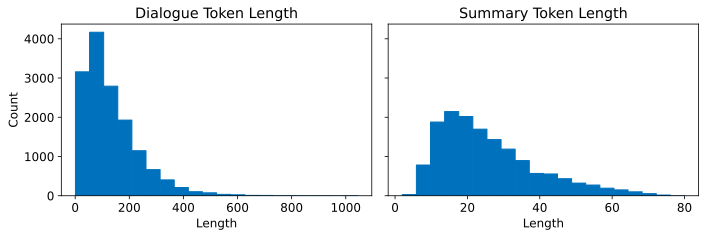

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

→ 토큰이 400미만에 몰려있고, 요약 토큰 길이도 20 부근에 몰려있음

데이터 콜레이터 만들기: 데이터를 모델이 처리할 수 있도록 적절한 형태로 변환하거나 조정<br>
대화 최대 길이: 1024<br>
요약 최대 길이: 128

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    # with tokenizer.as_target_tokenizer():                                     # 디코더 입력에 특수 토큰 필요, 디코더를 위한 토큰화임을 인지
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128,
                                    truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

PEGASUS: 인코더-디코더 트랜스포머, 고전적인 seq2seq 구조

In [20]:
# 티처 포싱(teacher forcing): seq2seq에서 사용하는 구조
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


※ Teacher Forcing 다른 예시

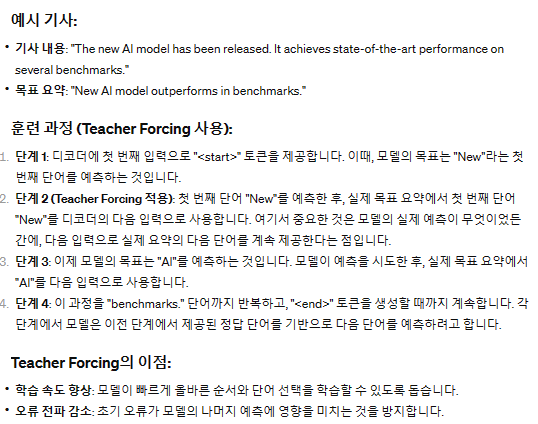

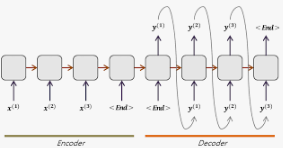

DataCollatorForSeq2Seq는 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만들고 레이블에 있는 패딩 토큰을 -100으로 설정해 손실함수가 무시하도록 처리

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

{'loss': 3.0125, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.0757, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.0213, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.9847, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.9439, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8873, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.8093, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.61, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.6594, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.3474, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.3726, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.2398, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.1204, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1171, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0179, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.0695, 'learning

100%|██████████| 410/410 [09:00<00:00,  1.32s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.429515,0.196094,0.341059,0.341279


In [ ]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.429515,0.196094,0.341059,0.341279


In [ ]:
trainer.push_to_hub("Training complete!")

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/haesun/pegasus-samsum/tree/main/'

### 6.6.3 대화 요약 생성하기

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="???/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah would rather she text him. Amanda will text him.


In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis, Leandro and Leandro are going to write a book about transformers.
They are going to do it together, but it's not easy.


## 6.7 결론

뭐든 사람의 판단이 아직은 가장 좋은 척도<br>
모델의 문맥 코기보다 긴 텍스트를 어떻게 요약할지가 문제...<br>
